In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sini = 0.5
g1 = 0.0
g2 = 0.05

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=g2)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.13636363636363635
slitAng_major_p: 21.008452488130185
slitAng_minor_p: 111.00845248813019


In [3]:
update_TF, _ = get_TFcube_pars()

update_TF['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)


# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    #data_info['data'] = data['spectra'][0] # this line is to make it compatible with older branches... 
    data_info['data_major'] = data['spectra'][0]
    data_info['data_minor'] = data['spectra'][1]
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 8.59 s, sys: 152 ms, total: 8.74 s
Wall time: 7.43 s


# 2D spec - major

In [4]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['r_0', 'v_spec', 'v_0', 'vscale'], data_key="data_major") #

params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda, par_init_guess={'vscale':0.5})
print(params_rot)

time cost in gaussFit_spec2D: 0.1726081371307373 (secs)
{'vscale': 0.49907965768071194, 'r_0': -0.04245224406602108, 'v_spec': 91.44361394093441, 'v_0': 0.4142463817309149, 'redshift': 0.1999999999088256}


In [5]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

100%|██████████| 3000/3000 [00:10<00:00, 291.27it/s]

Total MCMC time (mins): 0.17187480131785074


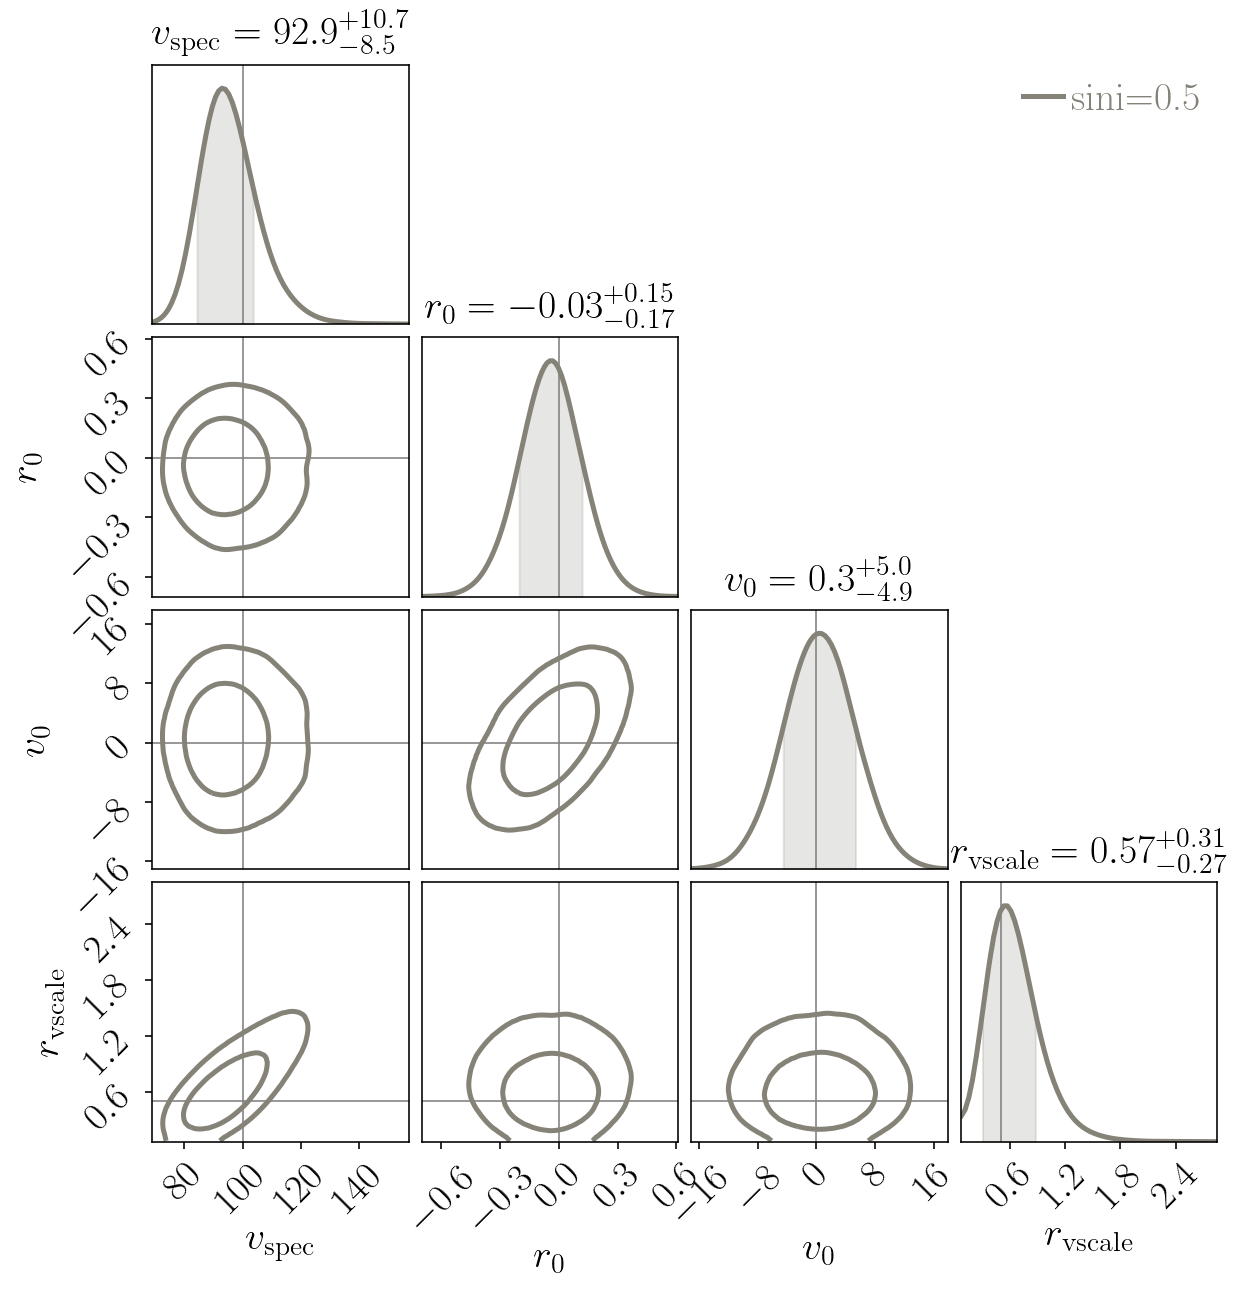

In [6]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['v_spec', 'r_0', 'v_0', 'vscale'] #, 'vscale'
legend_chain = "sini=%.1f"%sini

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# 2D spec - minor

In [7]:
# init Fit tool
RotFit_minor = RotationCurveFit(data_info, active_par_key = ['r_0', 'v_spec', 'v_0', 'vscale'], data_key="data_minor") #

params_rot_minor = RotFit_minor.optFit_rotation_curve(RotFit_minor.gaussfit_peakLambda, par_init_guess={'vscale':0.5})
print(params_rot_minor)

time cost in gaussFit_spec2D: 0.20064496994018555 (secs)
{'vscale': 0.4948564028327381, 'r_0': 0.05282707853647995, 'v_spec': -31.53720128997764, 'v_0': 0.5939997668533356, 'redshift': 0.1999999999909629}


In [8]:
# find fitting parameters using MCMC (get error bars as well)
chain_info_minor = RotFit_minor.run_MCMC(Nwalker=100, Nsteps=3000)
Chain_minor = ChainTool(chain_info_minor, Nburn=150000, Nend=300000)

100%|██████████| 3000/3000 [00:09<00:00, 321.29it/s]

Total MCMC time (mins): 0.15576242208480834


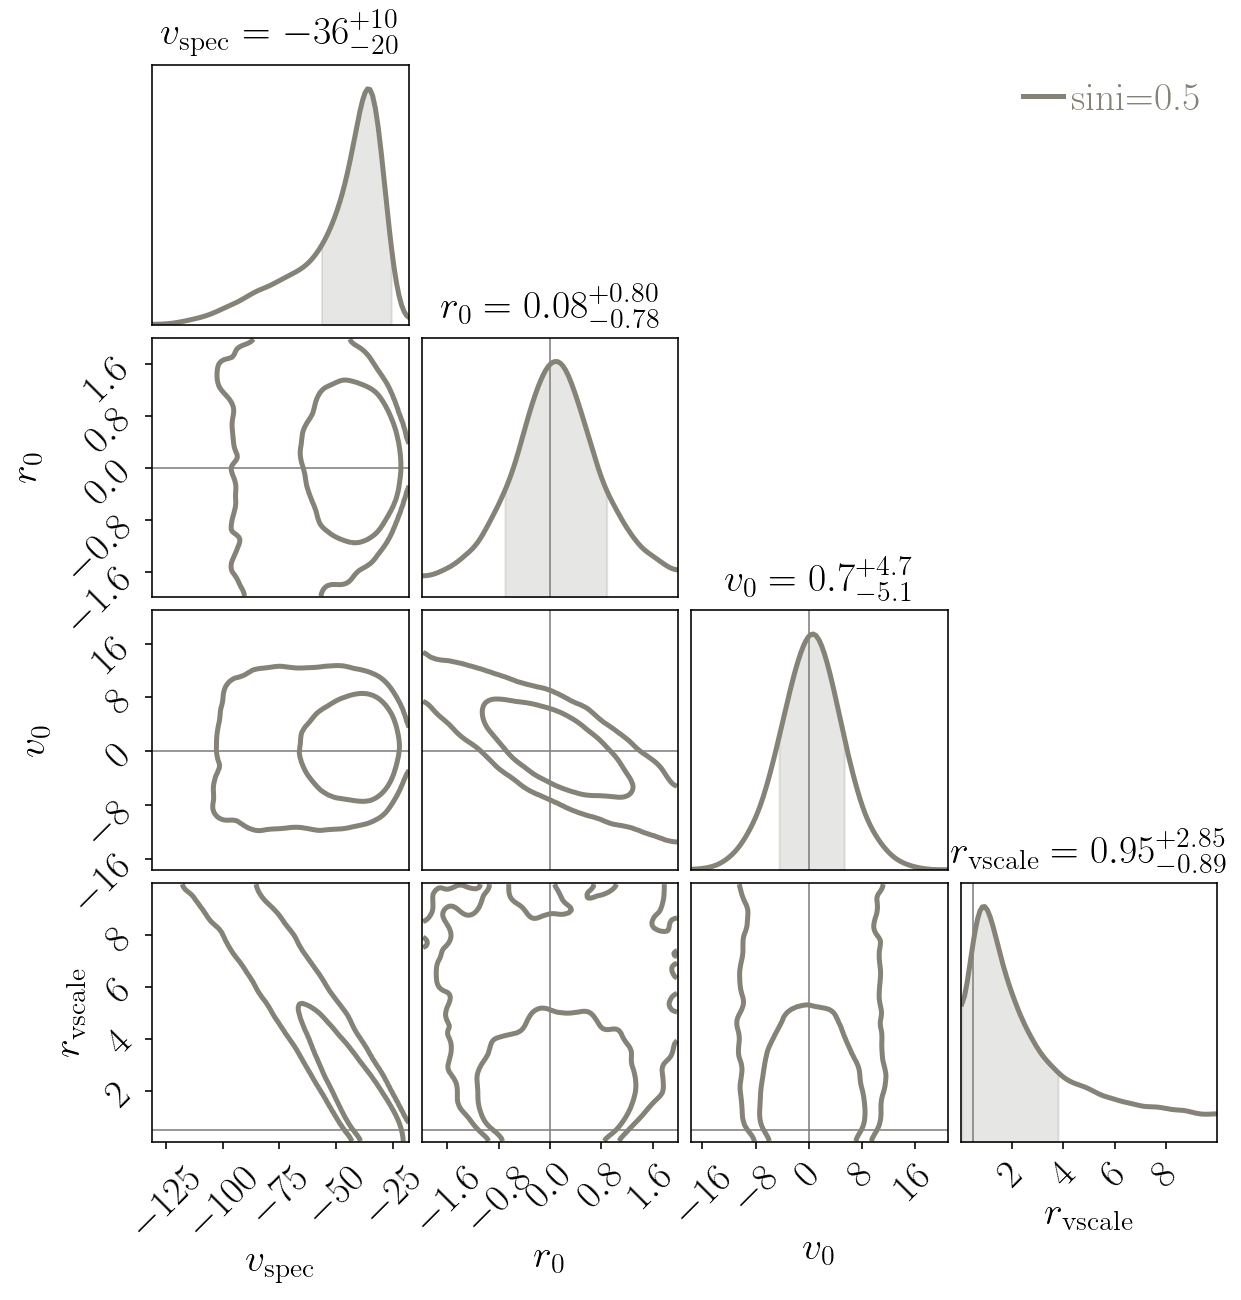

In [9]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['v_spec', 'r_0', 'v_0', 'vscale'] #, 'vscale'
legend_chain = "sini=%.1f"%sini

parID1,parName1,par_x1 = Chain_minor.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_minor.chain[:, parID1]       , parameters=parName1 ,name=legend_chain)

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)

c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# Plot spectrum

In [10]:
# get pixel edges
lambda_min = np.min(RotFit.grid_lambda)  ; lambda_MAX = np.max(RotFit.grid_lambda)
x_min = np.min(RotFit.grid_pos_ori)      ; x_MAX = np.max(RotFit.grid_pos_ori)

time cost in gaussFit_spec2D: 0.16769099235534668 (secs)


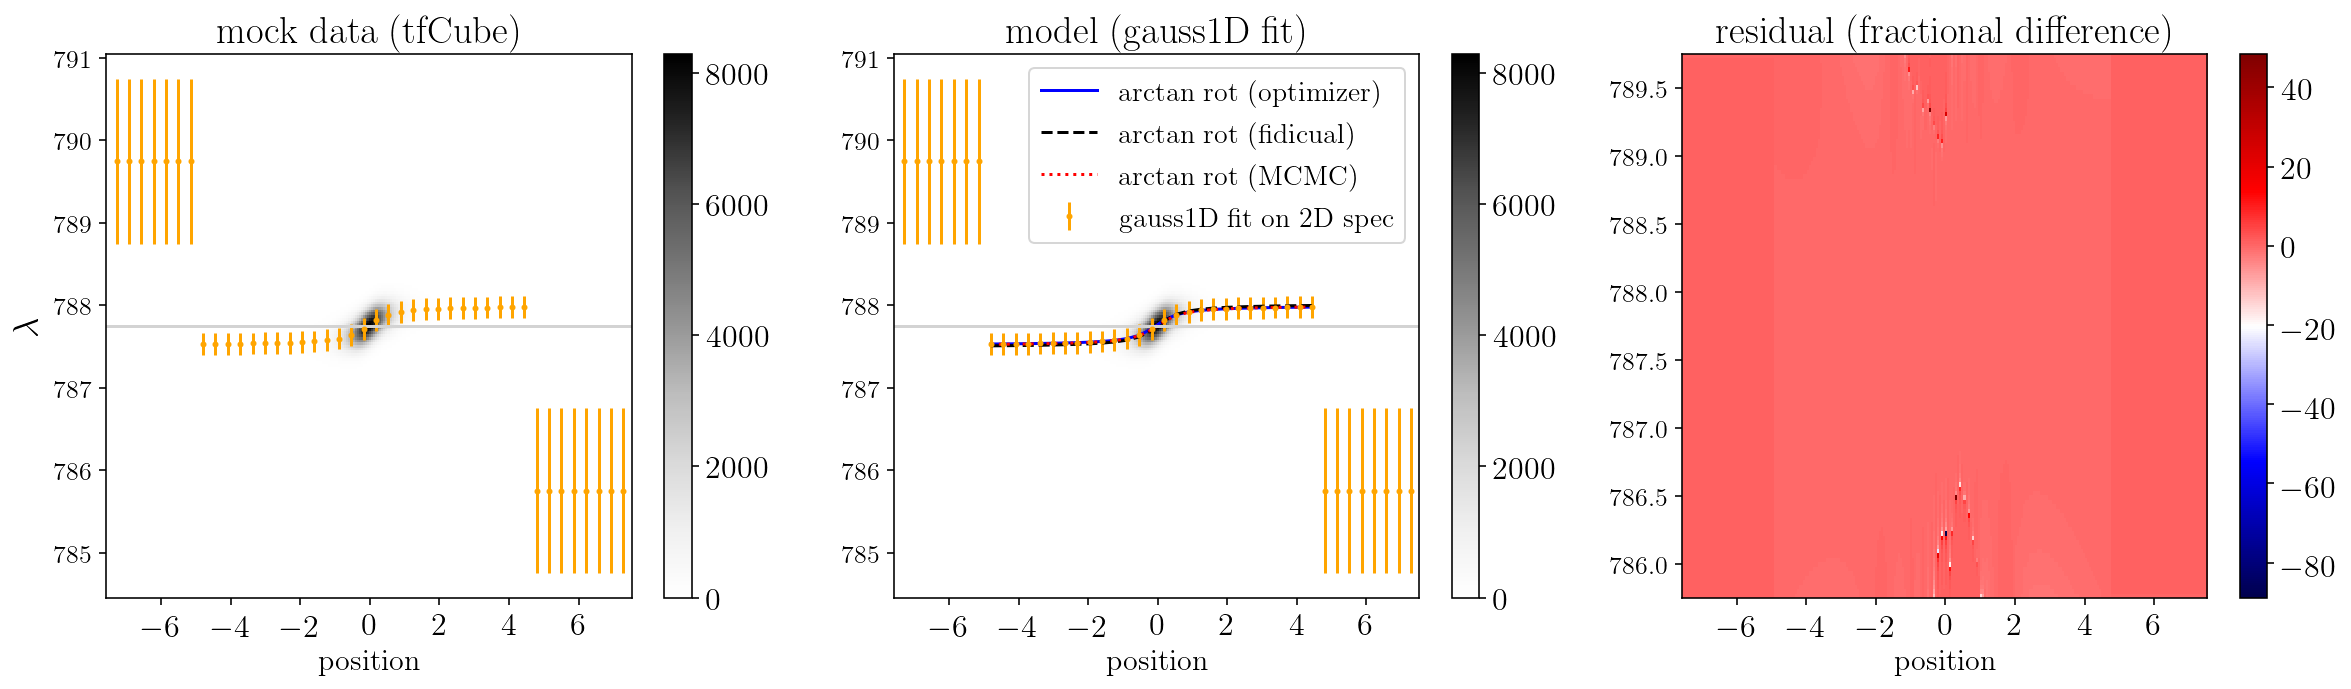

In [18]:
data = RotFit.data

fitted_peakLambda, fitted_amp, fitted_sigma = RotFit.gaussFit_spec2D(data=data)
model = RotFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)

grid_pos = RotFit.grid_pos_ori


%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img2=ax[2].imshow((data.T-model.T)/data.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])


#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(grid_pos[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')
ax[0].errorbar(grid_pos[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')


#### result of optimizer fit (blue)
ax[1].plot(RotFit.grid_pos[2::6], RotFit.fitted_rot_lambdaObs[2::6],color='b',ls='-',label='arctan rot (optimizer)')

#### result of fiducial rotation curve (black)
par = RotFit.Parameter.par_fid.copy()
fidicual_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par['vscale'], r_0=par['r_0'], v_spec=par['v_spec_major'], v_0=par['v_0'], redshift=par['redshift'])
ax[1].plot(RotFit.grid_pos[2::6],fidicual_rot[2::6],color='k',ls='--',label='arctan rot (fidicual)')

#### result of bestfit from MCMC sampling (red)
par_bestfit_MC = Chain.par_bestfit(select_par_key=None, statistics='max', mode=0)
MC_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par_bestfit_MC['vscale'][1], r_0=par['r_0'], v_spec=par_bestfit_MC['v_spec'][1], v_0=par['v_0'], redshift=par['redshift'])
ax[1].plot(RotFit.grid_pos[2::6],MC_rot[2::6],color='r',ls=':',label='arctan rot (MCMC)')


lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

ax[1].axhline(lambda_cen, color='lightgray')
ax[0].axhline(lambda_cen, color='lightgray')


for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (fractional difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()

time cost in gaussFit_spec2D: 0.19366765022277832 (secs)


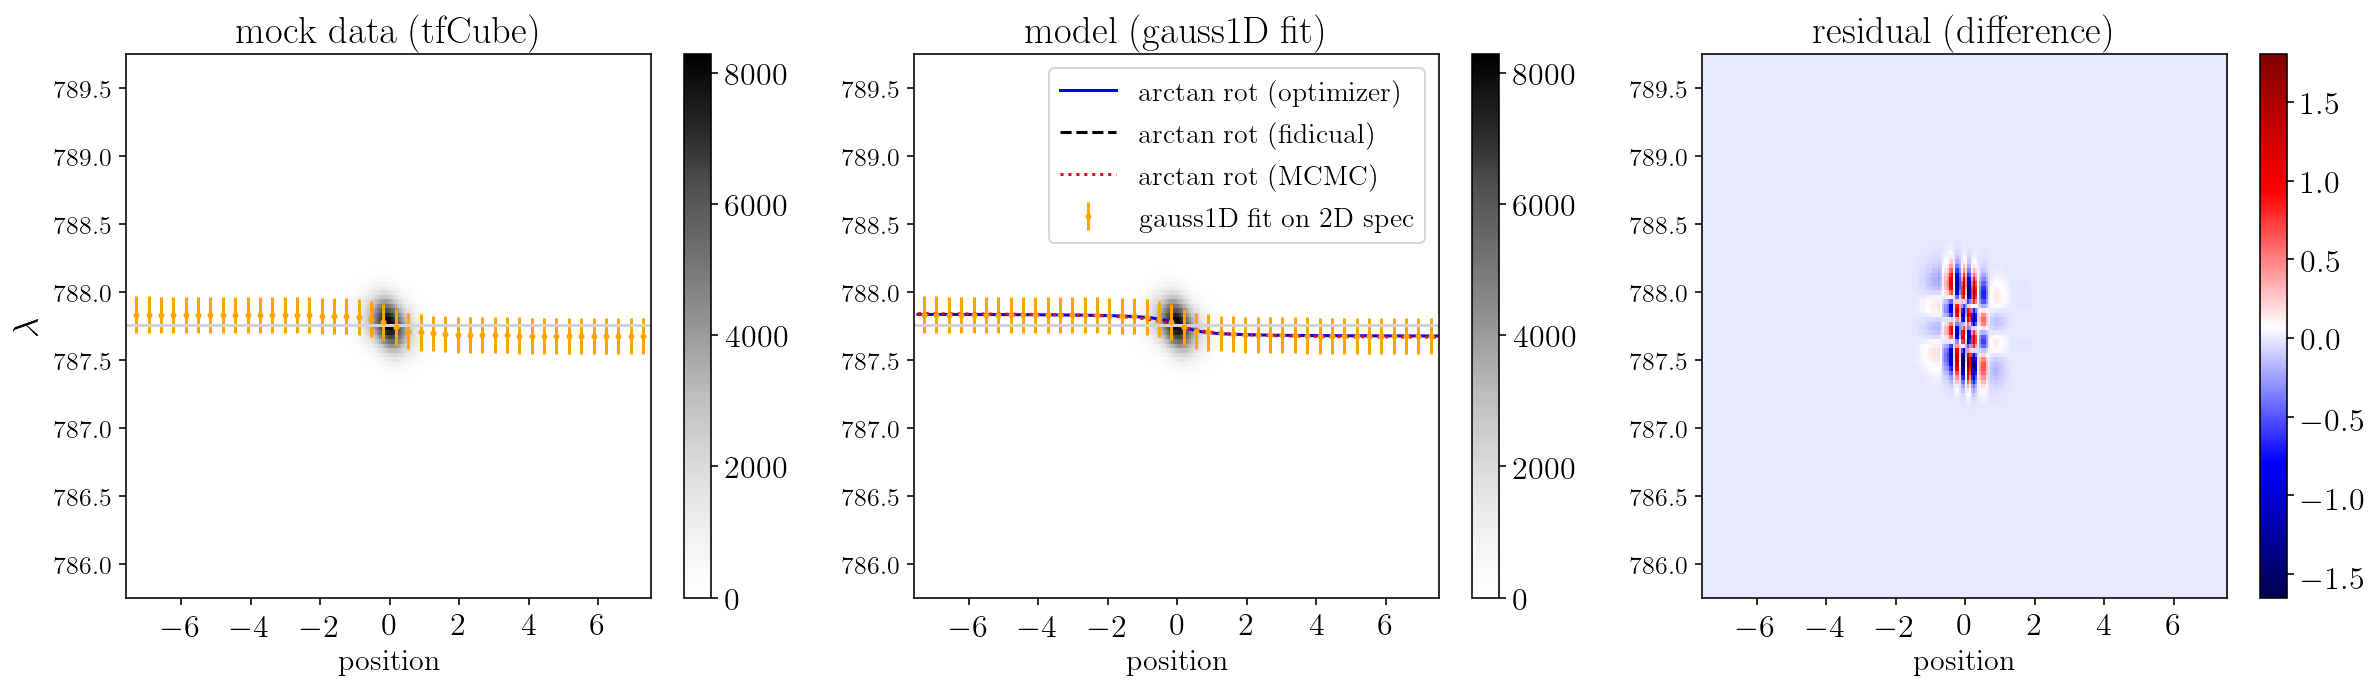

In [24]:
data = RotFit_minor.data

fitted_peakLambda, fitted_amp, fitted_sigma = RotFit_minor.gaussFit_spec2D(data=data)
model = RotFit_minor.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)

grid_pos = RotFit_minor.grid_pos_ori


%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img2=ax[2].imshow((data.T-model.T), extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])


#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(grid_pos[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')
ax[0].errorbar(grid_pos[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')


#### result of optimizer fit (blue)
ax[1].plot(RotFit_minor.grid_pos[2::6], RotFit_minor.fitted_rot_lambdaObs[2::6],color='b',ls='-',label='arctan rot (optimizer)')

#### result of fiducial rotation curve (black)
par = RotFit_minor.Parameter.par_fid.copy()
fidicual_rot = RotFit_minor.model_arctan_rotation(RotFit_minor.grid_pos, vscale=par['vscale'], r_0=par['r_0'], v_spec=par['v_spec_minor'], v_0=par['v_0'], redshift=par['redshift'])
ax[1].plot(RotFit_minor.grid_pos[2::6],fidicual_rot[2::6],color='k',ls='--',label='arctan rot (fidicual)')

#### result of bestfit from MCMC sampling (red)
par_bestfit_MC = Chain_minor.par_bestfit(select_par_key=None, statistics='max', mode=0)
MC_rot = RotFit_minor.model_arctan_rotation(RotFit_minor.grid_pos, vscale=par_bestfit_MC['vscale'][1], r_0=par['r_0'], v_spec=par_bestfit_MC['v_spec'][1], v_0=par['v_0'], redshift=par['redshift'])
ax[1].plot(RotFit_minor.grid_pos[2::6],MC_rot[2::6],color='r',ls=':',label='arctan rot (MCMC)')


lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

ax[1].axhline(lambda_cen, color='lightgray')
ax[0].axhline(lambda_cen, color='lightgray')


for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()